In [1]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Define BConvLSTM and Hidden Attention Module

import torch
import torch.nn as nn

# ConvLSTM Cell (single direction)
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = padding
        # Convolution for input-to-state and state-to-state transitions
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # For input, forget, cell, output gates
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        # Concatenate input and previous hidden state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # [batch, input_dim + hidden_dim, height, width]
        combined_conv = self.conv(combined)
        # Split into gates
        cc_i, cc_f, cc_c, cc_o = torch.split(combined_conv, self.hidden_dim, dim=1)
        # Gate activations
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        c_next = f * c_cur + i * torch.tanh(cc_c)  # Cell state
        h_next = o * torch.tanh(c_next)  # Hidden state
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# Bidirectional ConvLSTM
class BConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(BConvLSTM, self).__init__()
        self.forward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        self.backward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        # Final convolution to combine forward and backward outputs
        self.conv_out = nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=1, padding=0)

    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size, _, height, width = x.size()
        # Initialize hidden states
        h_f, c_f = self.forward_cell.init_hidden(batch_size, (height, width))
        h_b, c_b = self.backward_cell.init_hidden(batch_size, (height, width))
        
        # Forward pass
        h_forward = []
        for t in range(1):  # Single time step (as input is a single feature map)
            h_f, c_f = self.forward_cell(x, cur_state=[h_f, c_f])
            h_forward.append(h_f)
        h_forward = h_forward[0]  # [batch, hidden_dim, height, width]
        
        # Backward pass
        h_backward = []
        for t in range(1):  # Single time step
            h_b, c_b = self.backward_cell(x, cur_state=[h_b, c_b])
            h_backward.append(h_b)
        h_backward = h_backward[0]  # [batch, hidden_dim, height, width]
        
        # Combine forward and backward
        h_combined = torch.cat([h_forward, h_backward], dim=1)  # [batch, hidden_dim*2, height, width]
        output = self.conv_out(h_combined)  # [batch, hidden_dim, height, width]
        return output

# Hidden Attention Module with BConvLSTM
class HiddenAttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(HiddenAttentionModule, self).__init__()
        # First Conv Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second Conv Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # SE Block
        self.se_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Shortcut Connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        # BConvLSTM
        self.bconvlstm = BConvLSTM(input_dim=out_channels, hidden_dim=out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        # Conv Path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # SE Block
        se = self.se_block(out)
        out = out * se
        # Shortcut
        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)
        # BConvLSTM
        out = self.bconvlstm(out)
        return out

In [3]:
# Cell 4: Define HA-ResNet Model (with Dropout)
class HA_ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(HA_ResNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.ham1 = HiddenAttentionModule(64, 64, stride=1)
        self.ham2 = HiddenAttentionModule(64, 128, stride=2)
        self.ham3 = HiddenAttentionModule(128, 256, stride=2)
        self.ham4 = HiddenAttentionModule(256, 512, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.ham1(x)
        x = self.ham2(x)
        x = self.ham3(x)
        x = self.ham4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [4]:
# Cell 5: Define Custom Dataset
class GaitGAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
import os
print(os.getcwd())

C:\Users\piyus\mlenv\gaitenv


In [17]:
import os
os.chdir("gaf_images/")  # Adjust path
print(os.getcwd())

C:\Users\piyus\mlenv\gaitenv\gaf_images


In [18]:
import os
print(os.listdir('.'))

['als', 'best_ha_resnet.pth', 'control', 'hunt', 'park']


In [19]:
import os
cls_dir = "als"  # Try "ALS" if lowercase fails
if os.path.exists(cls_dir):
    print(f"Contents of {cls_dir}:", os.listdir(cls_dir))
else:
    print(f"{cls_dir} does not exist")

Contents of als: ['DoubleSupport', 'DoubleSupport%', 'L_Stance', 'L_Stance%', 'L_Stride', 'L_Swing', 'L_Swing%', 'R_Stance', 'R_Stance%', 'R_Stride', 'R_Swing', 'R_Swing%']


In [20]:
import os
feature_dir = os.path.join("als", "L_Stride")  # Try "ALS" if needed
if os.path.exists(feature_dir):
    images = [f for f in os.listdir(feature_dir) if f.endswith('.png')]
    print(f"Images in {feature_dir}:", len(images))
else:
    print(f"{feature_dir} does not exist")

Images in als\L_Stride: 13


In [21]:
# Cell 6: Load and Split Dataset (Fixed)
def load_gaf_images(gaf_dir="."):  # Use current directory
    classes = {'als': 0, 'control': 1, 'hunt': 2, 'park': 3}
    features = [
        'L_Stride', 'R_Stride', 'L_Swing', 'R_Swing', 'L_Swing%', 'R_Swing%',
        'L_Stance', 'R_Stance', 'L_Stance%', 'R_Stance%', 'DoubleSupport', 'DoubleSupport%'
    ]
    image_paths = []
    labels = []

    print(f"Looking for images in: {os.path.abspath(gaf_dir)}")
    if not os.path.exists(gaf_dir):
        print(f"Error: {gaf_dir} directory does not exist")
        return image_paths, labels

    for cls_name, cls_idx in classes.items():
        cls_dir = os.path.join(gaf_dir, cls_name)
        cls_dir_alt = os.path.join(gaf_dir, cls_name.upper())
        if os.path.exists(cls_dir):
            active_dir = cls_dir
        elif os.path.exists(cls_dir_alt):
            active_dir = cls_dir_alt
            print(f"Using {cls_name.upper()} instead of {cls_name}")
        else:
            print(f"Error: Neither {cls_dir} nor {cls_dir_alt} found")
            continue

        for feature in features:
            feature_dir = os.path.join(active_dir, feature)
            if not os.path.exists(feature_dir):
                print(f"Warning: {feature_dir} not found")
                continue
            for img_name in os.listdir(feature_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(feature_dir, img_name)
                    image_paths.append(img_path)
                    labels.append(cls_idx)

    print(f"Loaded {len(image_paths)} images")
    class_counts = Counter(labels)
    for cls_name, cls_idx in classes.items():
        print(f"{cls_name}: {class_counts[cls_idx]} images")
    
    if len(image_paths) != 768:
        print(f"Warning: Expected 768 images, found {len(image_paths)}. Verify dataset.")
    
    return image_paths, labels

def split_dataset(image_paths, labels, train_ratio=0.7, val_ratio=0.1):
    # Train+Val / Test split
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )
    # Train / Val split
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=val_ratio/(train_ratio+val_ratio),
        stratify=train_val_labels, random_state=42
    )
    return train_paths, val_paths, test_paths, train_labels, val_labels, test_labels

# Test loading
image_paths, labels = load_gaf_images(".")

Looking for images in: C:\Users\piyus\mlenv\gaitenv\gaf_images
Loaded 768 images
als: 156 images
control: 192 images
hunt: 240 images
park: 180 images


In [22]:
# Cell 7: Weighted Sampler and DataLoader Setup (with Augmentation)
def get_weighted_sampler(labels):
    class_counts = Counter(labels)
    num_samples = len(labels)
    weights = [num_samples / class_counts[label] for label in labels]
    sampler = WeightedRandomSampler(weights, num_samples, replacement=True)
    return sampler

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split dataset
image_paths, labels = load_gaf_images(".")
train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = split_dataset(image_paths, labels)

# Create datasets
train_dataset = GaitGAFDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GaitGAFDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = GaitGAFDataset(test_paths, test_labels, transform=val_test_transform)

# Create DataLoaders
batch_size = 16
train_sampler = get_weighted_sampler(train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_paths)} images, Val: {len(val_paths)} images, Test: {len(test_paths)} images")

Looking for images in: C:\Users\piyus\mlenv\gaitenv\gaf_images
Loaded 768 images
als: 156 images
control: 192 images
hunt: 240 images
park: 180 images
Train: 537 images, Val: 77 images, Test: 154 images


In [23]:
# Cell 8: Training and Evaluation Functions (Updated for Overfitting Check)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_true, train_preds, average='weighted', zero_division=0)

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='weighted', zero_division=0
        )

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        print(f"Unique predicted classes (val): {np.unique(val_preds)}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'best_ha_resnet.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_model_state

def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true, preds, average='weighted', zero_division=0
    )
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Unique predicted classes (test): {np.unique(preds)}")

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'],
                yticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/30
Train - Loss: 1.3524, Accuracy: 0.2812, F1: 0.2699
Val   - Loss: 1.3981, Accuracy: 0.2338, F1: 0.0886
Unique predicted classes (val): [3]
Epoch 2/30
Train - Loss: 1.2993, Accuracy: 0.3352, F1: 0.3289
Val   - Loss: 1.3511, Accuracy: 0.2727, F1: 0.1886
Unique predicted classes (val): [0 1 2 3]
Epoch 3/30
Train - Loss: 1.2819, Accuracy: 0.4060, F1: 0.3910
Val   - Loss: 1.3293, Accuracy: 0.4286, F1: 0.3829
Unique predicted classes (val): [0 1 2]
Epoch 4/30
Train - Loss: 1.3035, Accuracy: 0.3762, F1: 0.3708
Val   - Loss: 1.2256, Accuracy: 0.4675, F1: 0.4297
Unique predicted classes (val): [0 1 2 3]
Epoch 5/30
Train - Loss: 1.2636, Accuracy: 0.4153, F1: 0.3784
Val   - Loss: 1.4440, Accuracy: 0.2857, F1: 0.1886
Unique predicted classes (val): [0 1 2]
Epoch 6/30
Train - Loss: 1.2473, Accuracy: 0.4115, F1: 0.4107
Val   - Loss: 1.2967, Accuracy: 0.4156, F1: 0.3645
Unique predicted classes (val): [0 1 2 3]
Epoch 7/30
Train - Loss: 1.2342, Accuracy: 0.4413, F1: 0.3952
Val   - Loss: 1.25

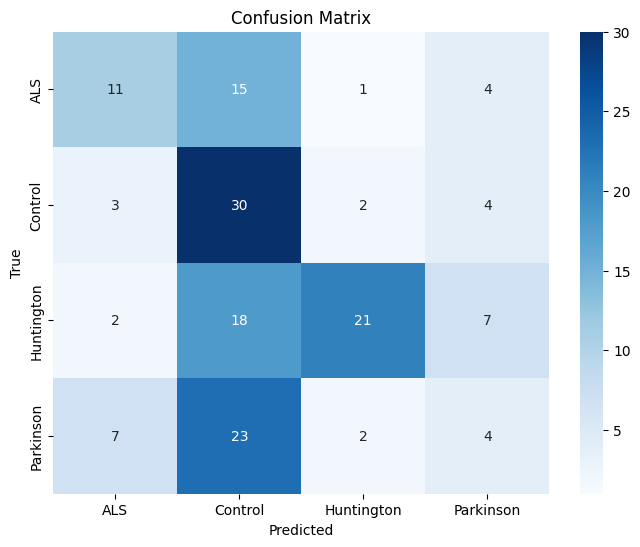

In [24]:
# Cell 9: Main Execution (with Early Stopping)
model = HA_ResNet(num_classes=4).to(device)
class_weights = torch.tensor([768/156, 768/192, 768/240, 768/180], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_epochs = 30
best_model_state = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5)
model.load_state_dict(torch.load('best_ha_resnet.pth'))
evaluate_model(model, test_loader, device)

In [ ]:
# Cell 10: Plot Training and Validation Curves
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_f1 = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Unique predicted classes (val): {np.unique(val_preds)}")

        if val_accuracy > best_val_f1:
            best_val_f1 = val_accuracy
            torch.save(model.state_dict(), 'best_ha_resnet.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Run training
model = HA_ResNet(num_classes=4).to(device)
class_weights = torch.tensor([768/156, 768/192, 768/240, 768/180], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate best model
model.load_state_dict(torch.load('best_ha_resnet.pth'))
evaluate_model(model, test_loader, device)